## Bit flip code

<img src="bit_flip.png" width="700" height="250" />

In [11]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.result import marginal_distribution
from qiskit.quantum_info import Statevector
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.circuit.library import UGate
from numpy.random import randint
import numpy as np


In [12]:
def encoder(qc):
    # Step 1 -> 2 (Bit flip code)
    qc.cx(0, 1)
    qc.cx(0, 2)

def syndrome_measurement(qc):
    # Measure the parity between 0 and 1
    qc.cx(0, 3)
    qc.cx(1, 3)
    qc.measure(3, 0)
    qc.barrier()
    # Measure the parity between 1 and 2
    qc.cx(1, 4)
    qc.cx(2, 4)
    qc.measure(4, 1)

def decoder(qc, n_qubit_error=None):
    if n_qubit_error is None:
        qc.cx(0, 1)
        qc.cx(0, 2)
    else:
        intact_qubits = list({0, 1, 2}.difference([n_qubit_error]))
        qc.cx(n_qubit_error, intact_qubits[0])
        qc.cx(n_qubit_error, intact_qubits[1])
        qc.ccx(intact_qubits[0], intact_qubits[1], n_qubit_error)
    


In [13]:
def qec_bit_flip(quantum_gate_state, qubit_error=None):
    if qubit_error is None:
        qubit_error = np.random.randint(4)

    tq = QuantumRegister(1, 'transmitted_qubit')
    cq1 = QuantumRegister(1, 'code_qubit1')
    cq2 = QuantumRegister(1, 'code_qubit2')
    aq = QuantumRegister(2, 'ancilla_qubit')
    sb = ClassicalRegister(2, 'syndrome_bit')

    qc = QuantumCircuit(tq, cq1, cq2, aq, sb)
    qc.append(quantum_gate_state, tq)
    qc.barrier()
    encoder(qc)
    qc.barrier()
    # ERROR
    if qubit_error < 3:
        qc.x(qubit_error)
        qc.barrier()

    syndrome_measurement(qc)
    qc.barrier()

    # Decoding
    check_result = ClassicalRegister(1, "Result")
    qc.add_register(check_result)
    with qc.if_test((sb, 0)):
        decoder(qc)
        # Measure check result
        qc.append(quantum_gate_state.inverse(), tq)
        qc.measure(tq, check_result)
    with qc.if_test((sb, 1)):
        decoder(qc, 0)
        # Measure check result
        qc.append(quantum_gate_state.inverse(), tq)
        qc.measure(tq, check_result)
    with qc.if_test((sb, 2)):
        decoder(qc, 2)
        # Measure check result
        qc.append(quantum_gate_state.inverse(), cq2)
        qc.measure(cq2, check_result)
    with qc.if_test((sb, 3)):
        decoder(qc, 1)
        # Measure check result
        qc.append(quantum_gate_state.inverse(), cq1)
        qc.measure(cq1, check_result)

    return qc

## ------------

In [14]:
random_gate = UGate(
                    theta=np.random.random() * 2 * np.pi,
                    phi=np.random.random() * 2 * np.pi,
                    lam=np.random.random() * 2 * np.pi,
                   )

random_gate.to_matrix()

array([[-0.29140178+0.j        , -0.77961538+0.55433281j],
       [-0.94798779-0.1280787j ,  0.25795868-0.13554453j]])

In [15]:
Statevector.from_label('0').evolve(random_gate).draw('latex')

<IPython.core.display.Latex object>

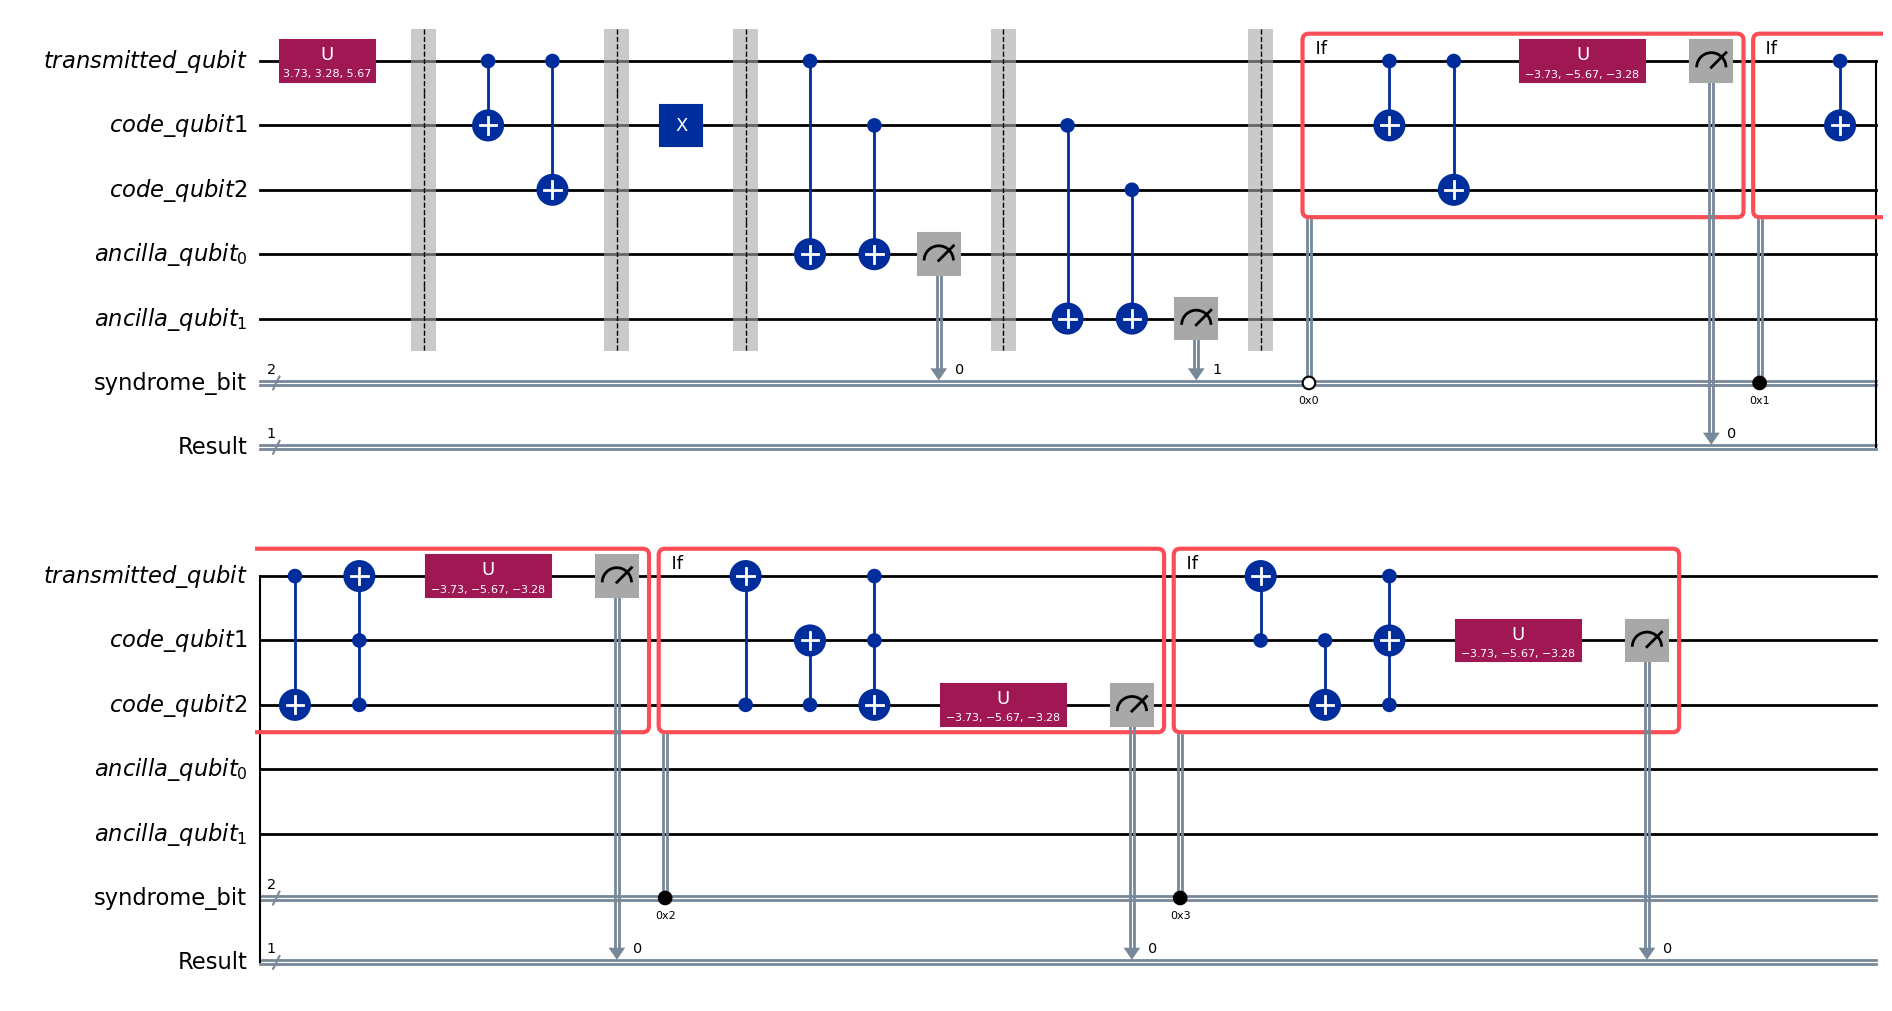

In [16]:
qc = qec_bit_flip(random_gate, 1)
qc.draw(output="mpl", style="iqp")

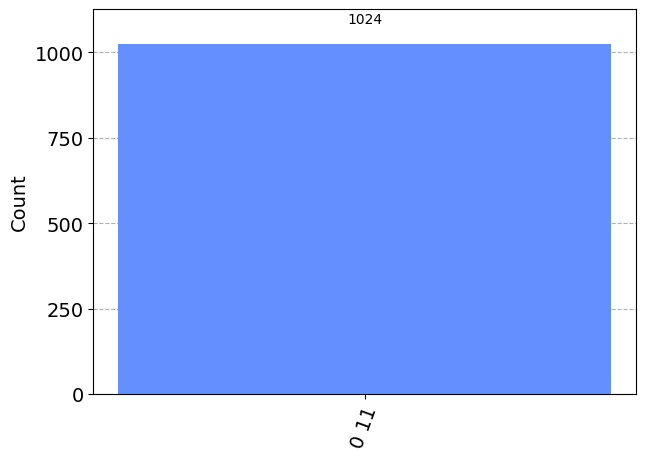

In [17]:

counts = AerSimulator().run(qc).result()
statistics = counts.get_counts()
display(plot_histogram(statistics))

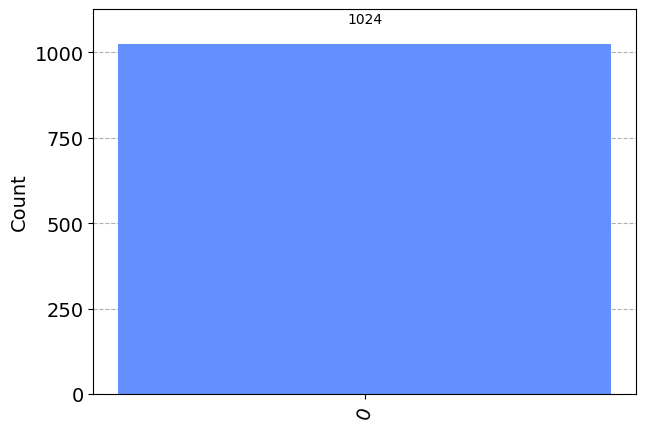

In [18]:
filtered_statistics = marginal_distribution(statistics, [2])
display(plot_histogram(filtered_statistics))